##### ***Import lib***

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn.calibration import CalibratedClassifierCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

##### ***Load data***

In [3]:
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')

In [4]:
import numpy as np
import pandas as pd

def create_financial_features(df):

    df = df.copy()

    required_cols = [
        'business_turnover', 'business_expenses', 
        'personal_income', 'owner_age', 'business_age_years'
    ]
    
    for col in required_cols:
        if col not in df.columns:
            df[col] = 0
            
    df['profit_margin'] = (
        (df['business_turnover'] - df['business_expenses']) / 
        df['business_turnover'].replace(0, np.nan)
    )
    
    df['expense_ratio'] = (
        df['business_expenses'] / 
        df['personal_income'].replace(0, np.nan)
    )
    
    df['age_per_year_business'] = (
        df['owner_age'] / 
        df['business_age_years'].replace(0, np.nan)
    )
    
    return df

train_df = create_financial_features(train_df)
test_df = create_financial_features(test_df)

In [5]:
def preprocess(train_df, test_df):
    X_train = train_df.drop(['ID', 'Target'], axis=1)

    test_ids = test_df['ID']
    X_test = test_df.drop(['ID'], axis=1)

    num_cols = X_train.select_dtypes(include=['number']).columns
    cat_cols = X_train.select_dtypes(include=['object']).columns

    imp_num = SimpleImputer(strategy='median')
    X_train[num_cols] = imp_num.fit_transform(X_train[num_cols])
    X_test[num_cols] = imp_num.transform(X_test[num_cols])

    imp_cat = SimpleImputer(strategy='most_frequent')
    X_train[cat_cols] = imp_cat.fit_transform(X_train[cat_cols])
    X_test[cat_cols] = imp_cat.transform(X_test[cat_cols])

    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

    X_train[cat_cols] = oe.fit_transform(X_train[cat_cols])
    X_test[cat_cols] = oe.transform(X_test[cat_cols])


    X_train["Target"] = train_df['Target']
    X_train["ID"] = train_df['ID']

    X_test["ID"] = test_df['ID']

    return X_train, X_test

train, test = preprocess(train_df, test_df)

#### ***Data saving***

In [7]:
train.to_csv("Preprocessed-Train_clean.csv", index=False)
test.to_csv("Preprocessed-Test_clean.csv", index=False)

##### ***Prepare training data***

In [5]:
X = train.drop(['ID', 'Target'], axis=1)

##### **Encode Target**

In [ ]:
le = LabelEncoder()
y = le.fit_transform(train['Target'])
print("Target Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Target Mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}


##### ***Split data***

In [ ]:

X_temp, X_test_internal, y_temp, y_test_internal = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp
)

print(f"Train Shape: {X_train.shape}, Val Shape: {X_val.shape}")

Train Shape: (5770, 40), Val Shape: (2886, 40)


##### ***Pipeline with SMOTE and RF***

In [8]:
pipe = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
        warm_start=False
    ))
])

##### ***Hyperparamerter distribuitons***

In [ ]:
param_dist = {
    "rf__n_estimators": randint(200, 1000), 
    "rf__max_depth": [8, 10, 12, 14, 20, None], 
    "rf__min_samples_split": randint(2, 25),
    "rf__min_samples_leaf": randint(1, 10),
    "rf__max_features": ["sqrt", "log2", 0.5],
    "rf__class_weight": ["balanced", "balanced_subsample"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rs = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=40,      
    scoring="f1_macro",
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42,
    refit=True
)

##### ***Run randomized search on your training set***

In [10]:
rs.fit(X_train, y_train)

print("Best params:", rs.best_params_)
print("Best CV f1_macro:", rs.best_score_)

best_model = rs.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'rf__class_weight': 'balanced', 'rf__max_depth': None, 'rf__max_features': 0.5, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 6, 'rf__n_estimators': 417}
Best CV f1_macro: 0.7914926933271219


##### ***Calibrate probabilities (optional)***

In [11]:

calibrated = CalibratedClassifierCV(best_model, cv=cv, method='sigmoid')
calibrated.fit(X_train, y_train)

,"estimator estimator: estimator instance, default=NoneThe classifier whose output need to be calibrated to provide moreaccurate `predict_proba` outputs. The default classifier isa :class:`~sklearn.svm.LinearSVC`... versionadded:: 1.2",Pipeline(step...m_state=42))])
,"method method: {'sigmoid', 'isotonic', 'temperature'}, default='sigmoid'The method to use for calibration. Can be:- 'sigmoid', which corresponds to Platt's method (i.e. a binary logistic regression model).- 'isotonic', which is a non-parametric approach.- 'temperature', temperature scaling.Sigmoid and isotonic calibration methods natively support only binaryclassifiers and extend to multi-class classification using a One-vs-Rest (OvR)strategy with post-hoc renormalization, i.e., adjusting the probabilities aftercalibration to ensure they sum up to 1.In contrast, temperature scaling naturally supports multi-class calibration byapplying `softmax(classifier_logits/T)` with a value of `T` (temperature)that optimizes the log loss.For very uncalibrated classifiers on very imbalanced datasets, sigmoidcalibration might be preferred because it fits an additional interceptparameter. This helps shift decision boundaries appropriately when theclassifier being calibrated is biased towards the majority class.Isotonic calibration is not recommended when the number of calibration samplesis too low ``(≪1000)`` since it then tends to overfit... versionchanged:: 1.8 Added option 'temperature'.",'sigmoid'
,"cv cv: int, cross-validation generator, or iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross-validation,- integer, to specify the number of folds.- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if ``y`` is binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. If ``y`` isneither binary nor multiclass, :class:`~sklearn.model_selection.KFold`is used.Refer to the :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors.Base estimator clones are fitted in parallel across cross-validationiterations.See :term:`Glossary ` for more details... versionadded:: 0.24",None
,"ensemble ensemble: bool, or ""auto"", default=""auto""Determines how the calibrator is fitted.""auto"" will use `False` if the `estimator` is a:class:`~sklearn.frozen.FrozenEstimator`, and `True` otherwise.If `True`, the `estimator` is fitted using training data, andcalibrated using testing data, for each `cv` fold. The final estimatoris an ensemble of `n_cv` fitted classifier and calibrator pairs, where`n_cv` is the number of cross-validation folds. The output is theaverage predicted probabilities of all pairs.If `False`, `cv` is used to compute unbiased predictions, via:func:`~sklearn.model_selection.cross_val_predict`, which are thenused for calibration. At prediction time, the classifier used is the`estimator` trained on all the data.Note that this method is also internally implemented in:mod:`sklearn.svm` estimators with the `probabilities=True` parameter... versionadded:: 0.24.. versionchanged:: 1.6 `""auto""` option is added and is the default.",'auto'
,sampling_strategy,'auto'
,random_state,42
,k_neighbors,5
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",417
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, s

##### ***Evaluate on validation set***

In [12]:
y_pred = calibrated.predict(X_val)
y_proba = calibrated.predict_proba(X_val)

print("--- Validation Report (after tuning + calibration) ---")

print(classification_report(y_val, y_pred, digits=4))
print("f1_macro:", f1_score(y_val, y_pred, average="macro"))

--- Validation Report (after tuning + calibration) ---
              precision    recall  f1-score   support

           0     0.7768    0.6170    0.6877       141
           1     0.8820    0.9719    0.9247      1884
           2     0.8553    0.6934    0.7659       861

    accuracy                         0.8714      2886
   macro avg     0.8380    0.7608    0.7928      2886
weighted avg     0.8689    0.8714    0.8658      2886

f1_macro: 0.7927900238592711


### ***Confusion matrix***

[[  87    5   49]
 [   1 1831   52]
 [  24  240  597]]


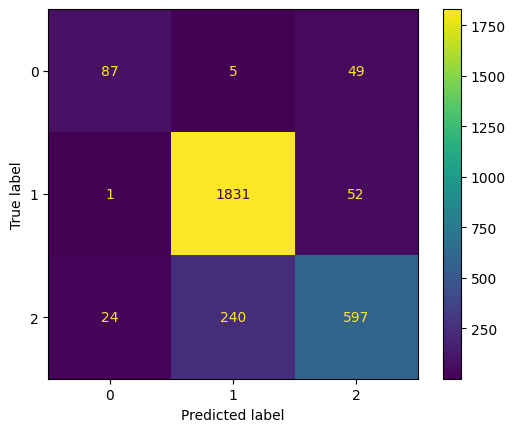

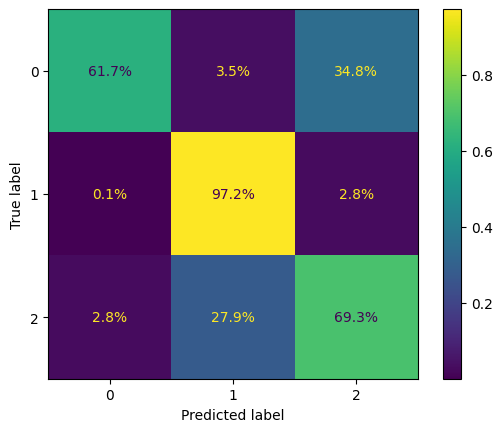

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred)
print(cm)
disp =  ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=calibrated.classes_)
disp.plot()
plt.show()

ConfusionMatrixDisplay.from_predictions(
    y_val, 
    y_pred, 
    normalize='true', 
    values_format='.1%',
    display_labels=calibrated.classes_
)
plt.show()

##### ***Predict on External Test Data***

In [14]:
X_submission = test.drop(["ID"], axis=1)

final_preds_encoded = calibrated.predict(X_submission)

import pandas as pd

inv_map = {0: 'High', 1: 'Low', 2: 'Medium'}

final_preds_labels = [inv_map[p] for p in final_preds_encoded]

submission_df = pd.DataFrame({
    'Id':test_df["ID"],
    'Target': final_preds_labels
})

submission_df.to_csv('predictions.csv', index=False)

print("File saved successfully as predictions.csv")

File saved successfully as predictions.csv


#### ***Model saving***

In [15]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(calibrated, f)

print("Model saved successfully as model.pkl")

Model saved successfully as model.pkl
